In [31]:
# -*- coding: utf-8 -*-
"""Nengo_Test.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1xRVok_mvkJxz_bFx0qHfQ5Uyk_yHGFjX
"""


import time
import nengo
import nengo_dl
import numpy as np

# Commented out IPython magic to ensure Python compatibility.
# %matplotlib inline
from urllib.request import urlretrieve
import tensorflow as tf
import scipy.io as sio
import logging
tf.get_logger().setLevel(logging.ERROR)

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from nengo.utils.ensemble import response_curves, tuning_curves
from nengo_extras.plot_spikes import (
    cluster,
    merge,
    plot_spikes,
    preprocess_spikes,
    sample_by_variance,
)




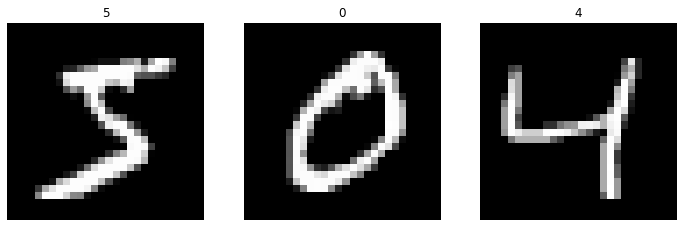

In [32]:
(train_images, train_labels), (
    test_images,
    test_labels,
) = tf.keras.datasets.mnist.load_data()

# flatten images
train_images = train_images.reshape((train_images.shape[0], -1))
test_images = test_images.reshape((test_images.shape[0], -1))

plt.figure(figsize=(12, 4))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.imshow(np.reshape(train_images[i], (28, 28)), cmap="gray")
    plt.axis("off")
    plt.title(str(train_labels[i]))


X_train = train_images[:100] # Taking few sample for quick training
Y_train = train_labels[:100]

X_test = X_train
Y_test = Y_train
n_class = len(np.unique(Y_test))

In [33]:
with nengo.Network(seed=0) as net:
    # set some default parameters for the neurons that will make
    # the training progress more smoothly
#     net.config[nengo.Ensemble].max_rates = nengo.dists.Choice([100])
    net.config[nengo.Ensemble].max_rates = nengo.dists.Choice([100])
    net.config[nengo.Ensemble].intercepts = nengo.dists.Choice([0])
    
    net.config[nengo.Connection].synapse = None
 
    neuron_type =nengo.LIF(amplitude = 0.001,tau_rc=0.02,tau_ref = 0.002)

    # this is an optimization to improve the training speed,
    # since we won't require stateful behaviour in this example
    nengo_dl.configure_settings(stateful=False)

    # the input node that will be used to feed in input images
    inp = nengo.Node(np.zeros(28 * 28))
    probe_in = nengo.Probe(inp, label="probe_in")

    # add the first convolutional layer
    x1 = nengo_dl.Layer(tf.keras.layers.Conv2D(filters=3, kernel_size=3))(
        inp, shape_in=(28, 28, 1)
    )
#     x1 = nengo_dl.Layer(tf.keras.layers.Dense(32, activation = "linear"))(inp, shape_in=(1,28*28))

#     x1 = nengo_dl.Layer(neuron_type)(x1)
    probe_l1 = nengo.Probe(x1, label="probe_l1")
    
    x2 = nengo_dl.Layer(tf.keras.layers.Dense(32, activation = "linear"))(x1)
    x2 = nengo_dl.Layer(neuron_type)(x2)
    probe_l2 = nengo.Probe(x2, label="probe_l2")
     

    # linear readout
    out = nengo_dl.Layer(tf.keras.layers.Dense(units=n_class))(x2)
    out_p = nengo.Probe(out, label="out_p")
    out_p_filt = nengo.Probe(out, synapse=0.01, label="out_p_filt")
    probe_l3 = nengo.Probe(out, label="probe_l3")
    probe_l3_filt = nengo.Probe(out, synapse=0.01, label="probe_l3_filt")

minibatch_size = 1

sim = nengo_dl.Simulator(net, minibatch_size=minibatch_size)

X_train = X_train[:, None, :]
Y_train =  Y_train[:, None, None]

# timesteps.
n_steps = 25

X_test = np.tile(X_test[:, None, :], (1, n_steps, 1))
Y_test = np.tile(Y_test[:, None, None], (1, n_steps, 1))


def classification_accuracy(y_true, y_pred):
    return tf.metrics.sparse_categorical_accuracy(y_true[:, -1], y_pred[:, -1])


# note that we use `out_p_filt` when testing (to reduce the spike noise)
sim.compile(loss={out_p_filt: classification_accuracy})
print(
    "Accuracy before training:",
    sim.evaluate(X_test, {out_p_filt: Y_test}, verbose=0)["loss"],
)


sim.compile(
    optimizer=tf.optimizers.Adam(0.011),
    loss={out_p: tf.losses.SparseCategoricalCrossentropy(from_logits=True)},
)

sim.fit(X_train, {out_p: Y_train}, epochs=2, verbose=1)


sim.save_params("./model_weights")

Train_acc  = sim.evaluate(X_test, {out_p_filt: Y_test}, verbose=0)["loss"]



# print(sim.keras_model.weights)
print(
    "Accuracy after training:",Train_acc
   
)

# print("--------------------")
# Layer_1 = sim.get_nengo_params(x1)
Layer_2 = sim.get_nengo_params(x2)

# np.save('./L1_params', Layer_1)
np.save('./L2_params', Layer_2)


Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:00                                               
Accuracy before training: 0.07999999821186066:00:00                            
Epoch 1/2
100/100 [==============================] - 5s 6ms/step - loss: 2.2949 - out_p_loss: 2.2949
Epoch 2/2
100/100 [==============================] - 1s 5ms/step - loss: 2.0639 - out_p_loss: 2.0639
Accuracy after training: 0.0age finished in 0:00:00                            


Constructing graph: build stage finished in 0:00:00                            

C:\Users\Arsalan\Anaconda3\envs\SNN_P\lib\site-packages\nengo_dl\simulator.py:2097: RuntimeWarning: Simulator with model=Model: <Network (unlabeled) at 0x1dae13edd60>, dt=0.001000 was deallocated while open. Simulators should be closed manually to ensure resources are properly freed.
  warnings.warn(


Predicted label: [0]


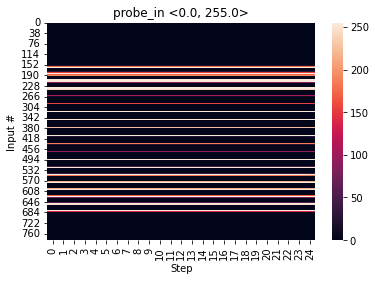

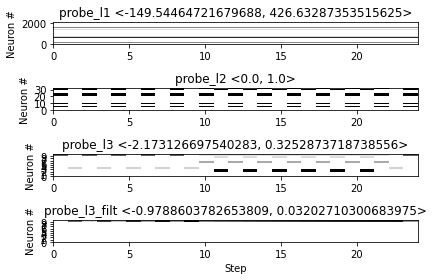

In [34]:
data = sim.predict(X_test[:1], verbose=0)

prediction = np.argmax(data[probe_l3_filt][:, -1], axis=-1)

print("Predicted label:", prediction)

steps = np.arange(n_steps)


plt.figure().gca()
plt.title(f'probe_in <{np.min(data[probe_in])}, {np.max(data[probe_in])}>')
import seaborn as sns
sns.heatmap(np.squeeze(data[probe_in]).T)
plt.xlabel("Step")
plt.ylabel("Input #")

ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.subplot(4, 1, 1)
plt.title(f'probe_l1 <{np.min(data[probe_l1])}, {np.max(data[probe_l1])}>')
plot_spikes(steps, np.squeeze(data[probe_l1]))
plt.ylabel("Neuron #")

plt.subplot(4, 1, 2)
plt.title(f'probe_l2 <{np.min(data[probe_l2])}, {np.max(data[probe_l2])}>')
plot_spikes(steps, np.squeeze(data[probe_l2]))
plt.yticks(np.arange(0, np.shape(data[probe_l2])[-1], 10))
plt.ylabel("Neuron #")

plt.subplot(4, 1, 3)
plt.title(f'probe_l3 <{np.min(data[probe_l3])}, {np.max(data[probe_l3])}>')
plot_spikes(steps, np.squeeze(data[probe_l3]))
plt.yticks(np.arange(0, np.shape(data[probe_l3])[-1]))
plt.ylabel("Neuron #")

plt.subplot(4, 1, 4)
plt.title(f'probe_l3_filt <{np.min(data[probe_l3_filt])}, {np.max(data[probe_l3_filt])}>')
plot_spikes(steps, np.squeeze(data[probe_l3_filt]))
plt.yticks(np.arange(0, np.shape(data[probe_l3_filt])[-1]))
plt.xlabel("Step")
plt.ylabel("Neuron #")

np.savetxt('./probe_in.csv', np.squeeze(data[probe_in]), delimiter=",")
np.savetxt('./probe_l1.csv', np.squeeze(data[probe_l1]), delimiter=",")
np.savetxt('./probe_l2.csv', np.squeeze(data[probe_l2]), delimiter=",")
np.savetxt('./probe_l3.csv', np.squeeze(data[probe_l3]), delimiter=",")
np.savetxt('./probe_l3_filt.csv', np.squeeze(data[probe_l3_filt]), delimiter=",")

plt.tight_layout()
plt.show()


In [35]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import numpy as np

def step(dt, J, output, voltage, refractory_time, tau_rc=0.02, min_voltage=0, amplitude=0.001, tau_ref=0.002):
    """"Adapted from nengo/nengo/neurons.py step() for LIF neuron https://github.com/nengo/nengo/blob/e87d2bee35ee89a23be7ac0a32515ebd09de6d1e/nengo/neurons.py"""
    """dt: float Simulation timestep.
    J: (n_neurons,) array_like Input currents associated  with each neuron.
    output: (n_neurons,) array_like Output activity associated with each neuron (e.g., spikes or firing rates)."""
    # look these up once to avoid repeated parameter accesses

    # reduce all refractory times by dt
    refractory_time -= dt
#     print(refractory_time)

    # compute effective dt for each neuron, based on remaining time.
    # note that refractory times that have completed midway into this
    # timestep will be given a partial timestep, and moreover these will
    # be subtracted to zero at the next timestep (or reset by a spike)
    delta_t = np.clip((dt - refractory_time), 0, dt)

    # update voltage using discretized lowpass filter
    # since v(t) = v(0) + (J - v(0))*(1 - exp(-t/tau)) assuming
    # J is constant over the interval [t, t + dt)
    voltage -= (J - voltage) * np.expm1(-delta_t / tau_rc)

    # determine which neurons spiked (set them to 1/dt, else 0)
    spiked_mask = voltage > 1
    output[:] = spiked_mask * (amplitude / dt)

    # set v(0) = 1 and solve for t to compute the spike time
    t_spike = dt + tau_rc * np.log1p(
        -(voltage[spiked_mask] - 1) / (J[spiked_mask] - 1)
    )

    # set spiked voltages to zero, refractory times to tau_ref, and
    # rectify negative voltages to a floor of min_voltage
    voltage[voltage < min_voltage] = min_voltage
    voltage[spiked_mask] = 0
    refractory_time[spiked_mask] = tau_ref + t_spike

    return spiked_mask


d_time = 0.001 #sec
time_steps = 25
neurons_l2 = 32

# output from the previous layer - to be used as an input
probe_l1_path = "./probe_l1.csv"
probe_l1 = np.genfromtxt(probe_l1_path, delimiter=',')

# reference SNN output
probe_l2_path = "./probe_l2.csv"
probe_l2 = np.genfromtxt(probe_l2_path, delimiter=',')

snnWeights = np.load('./model_weights.npz')
# print(snnWeights)
weights_l1_l2 = snnWeights['arr_3']
weights_bias_l2 = snnWeights['arr_4']

bias_lif_l2 = Layer_2["bias"]


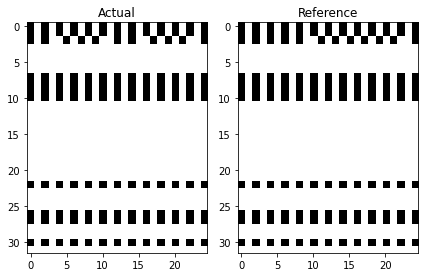

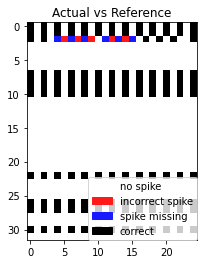

In [36]:
output = np.zeros(neurons_l2)
voltage = np.zeros(neurons_l2)
refractory_time = np.zeros(neurons_l2)

output_log = np.zeros((time_steps, neurons_l2))
voltage_log = np.zeros((time_steps, neurons_l2))
current_log = np.zeros((time_steps, neurons_l2))



for t_step in range(time_steps):  
    xw =  np.matmul((probe_l1[t_step]), weights_l1_l2) +  weights_bias_l2    
#     xw = tf.keras.activations.linear(xw)
    current_in = xw + bias_lif_l2
    output_log[t_step] = step(d_time, current_in, output, voltage, refractory_time, tau_rc=0.02, min_voltage=0, amplitude=0.001, tau_ref=0.002)
    voltage_log[t_step] = voltage
    current_log[t_step] = current_in

plt.figure().gca()
plt.subplot(1, 2, 1)
plt.title("Actual")
plt.imshow(output_log.T, cmap='Greys',  interpolation='nearest')
plt.subplot(1, 2, 2)
plt.title("Reference")
plt.imshow(probe_l2.T, cmap='Greys',  interpolation='nearest')
plt.tight_layout()

plt.figure()
plt.title("Actual vs Reference")
t = 1
cmap = {0: [1.0, 1.0, 1.0, t], 1: [1.0, 0.1, 0.1, t], 2: [0.1, 0.1, 1.0, t], 3: [0.0, 0.0, 0.0, t]}
labels = {0: 'no spike', 1: 'incorrect spike',2: 'spike missing',3: 'correct'}
data = (output_log.T + probe_l2.T*2).astype(int)
arrayShow = np.array([[cmap[i] for i in j] for j in data])
patches =[mpatches.Patch(color=cmap[i],label=labels[i]) for i in cmap]
plt.imshow(arrayShow)
plt.legend(handles=patches, loc=4, borderaxespad=0.)
plt.show()
